In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from matplotlib.colors import LogNorm
from scipy.interpolate import RectBivariateSpline

from copy import deepcopy

import quasiclassical_solver as qs
from legendre import *

In [2]:
au2cm = 219474.63
au2ps = 2.4188843265864e-5
au2eV = 27.2
au2A = 0.529177
Db2au = 0.393456
u2au = 1822.88839

In [3]:
class Potential:
    def __init__(self, D_6, R_6, a, b, R_a, R_b, R_c):
        self.D_6, self.R_6, self.a, self.b, self.R_a, self.R_b, self.R_c = D_6, R_6, a, b, R_a, R_b, R_c

        pass

    @staticmethod
    def default():
        return Potential( 500 / au2cm, 10., 0., 0., 0., 0., 0. )

    def set_Lennard_Jones(self, D_6 = 500 / au2cm, R_6 = 10.):
        self.D_6, self.R_6 = D_6, R_6
        pass

    def set_anisotropy(self, a = 0.0, b = 0.0):
        self.a, self.b = a, b
        pass

    def set_R_shift(self, R_a = 0.0, R_b = 0.0, R_c = 0.0):
        self.R_a, self.R_b, self.R_c = R_a, R_b, R_c
        pass


    def get_R_shifted(self, R, th):
        return R + self.R_a * np.cos(th)**2 + self.R_b * np.sin(th)**2 + self.R_c * np.cos(th)

    def get_lennard_jones(self, R):
        x = ( self.R_6 / R )**6
        return self.D_6 * ( x - 2 ) * x
    
    def get_anisotropy(self, th):
        return 1 + self.a * np.cos(th)**2 + self.b * np.sin(th)**2
    

    def value(self, R, th):
        if len( R.shape ) == 1:
            R = np.reshape( R, (1, -1) )
            th = np.reshape( th, (-1, 1) )

        R_shift = self.get_R_shifted( R, th )
        
        return self.get_lennard_jones( R_shift ) * self.get_anisotropy( th )


potential = Potential.default()

pass

In [32]:
solv = qs.Quasi_classic( m_rot = (16 + 32 + 12) * u2au, 
                        Be_rot = 0.20286/au2cm, 
                        m_proj = 20 * u2au,
                        th_av = True
                        )


def get_solv_arr(PES, j_init = [0, 1, 5]):

        solv.set_potential( PES )

        solv_arr = []

        for j in j_init:

                solv.set_hilbert_space( max_l = 160, max_m = j)

                solv.set_initial_conditions( E_col = 3700 * 3.1668105e-6, 
                                        r_0 = 30.0, 
                                        l_0 = j 
                                        )

                solv.solve( t_max = 6e4,
                        kwargs={"first_step": 1e3, "t_eval": np.linspace(0,6e4,1000),
                                "atol": 1e-7, "rtol": 1e-5}
                        ) 

                print( f"j_init={j} finished" )
                solv_arr.append( deepcopy( solv ) )
        return solv_arr
pass

In [33]:
sh_el = [ {}, {"R_a":0.1}, {"R_b":0.1}, {"R_c":0.2} ]
an_el = [ {"a":1}, {"b":1} ]

par_an_list = [{"a":1}]
par_sh_list = [{"R_c":0.2}]

# for an in an_el:
#     for sh in sh_el:
#         par_an_list.append( an )
#         par_sh_list.append( sh )


def get_fname(par_an, par_sh):
    return "".join([ f"{key}_{par_an[key]}_" for key in par_an ]) + \
        "".join([ f"{key}_{par_sh[key]}_" for key in par_sh ])

j_init = [0, 1, 5]

for par_an, par_sh in zip( par_an_list, par_sh_list ):

    potential.set_anisotropy(**par_an)
    potential.set_R_shift(**par_sh)

    solv_arr = get_solv_arr(potential.value, j_init)


    fig, ax = plt.subplots()
    ax_r = ax.twinx()

    for j, solv in zip( j_init, solv_arr ):
        p = ax.plot( solv.t * au2ps, solv.alignment, label = r"$j_{init} = $" + str(j) )
        ax_r.plot( solv.t * au2ps, solv.r, color = p[0].get_color(), alpha = 0.5 )

    ax.set_xlabel( "time [ps]" )
    ax.set_ylabel( r"$\left< \cos^2(\theta) \right>$" )
    ax_r.set_ylabel( "distance [bohr]" )

    ax.legend()
    ax.grid()

    ax.set_ylim( 0, 1 )

    fig.savefig( get_fname(par_an, par_sh)+f"alignment{'_th_av' if solv.th_av else ''}.pdf" )

    fig.clf()

pass

j_init=0 finished
j_init=1 finished
j_init=5 finished


<Figure size 640x480 with 0 Axes>

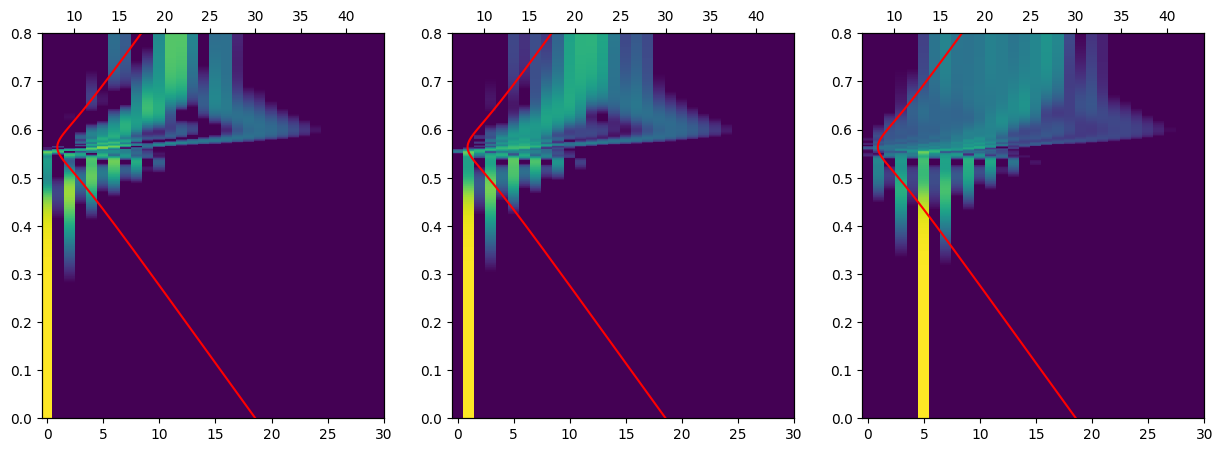

In [34]:
N_j = len( j_init )

fig, ax_list = plt.subplots(1, N_j, figsize=(15, 5))

L_plot_max = 30

for ax, j, solv in zip( ax_list, j_init, solv_arr ):
    
    l_max = np.max( solv.l_arr )
    rot_prob = np.zeros( (solv.N_t, l_max + 1) )

    for i, l in enumerate( solv.l_arr ):
        rot_prob[:, l] += np.abs( solv.Psi[:, i] )**2

    l_arr = np.arange( l_max+1 )

    ax.pcolor( l_arr, solv.t * au2ps, rot_prob, norm = LogNorm(vmin = 1e-2) )

    ax.set_xlim( -0.5, L_plot_max )
    ax.set_ylim( 0.0, 0.8 )

    ax_r = ax.twiny()
    ax_r.plot( solv.r, solv.t * au2ps, 'r' )



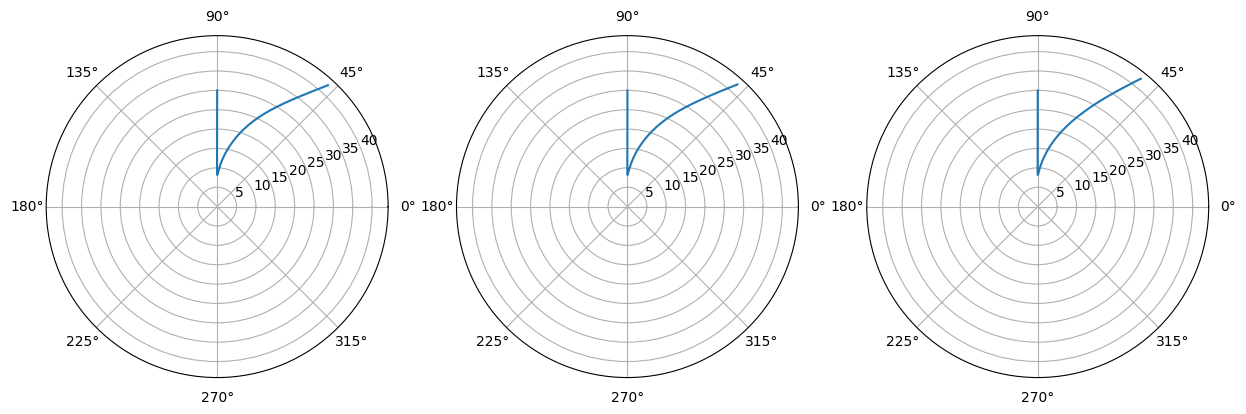

In [45]:
N_j = len( j_init )

fig, ax_list = plt.subplots(1, N_j, figsize=(15, 5),subplot_kw={'projection': 'polar'})

L_plot_max = 30

for ax, j, solv in zip( ax_list, j_init, solv_arr ):
    
    th_av = np.sum( np.abs( solv.Psi_ang )**2 * solv.w_all * solv.th_all, axis = 1 )
    ax.plot( th_av, solv.r )



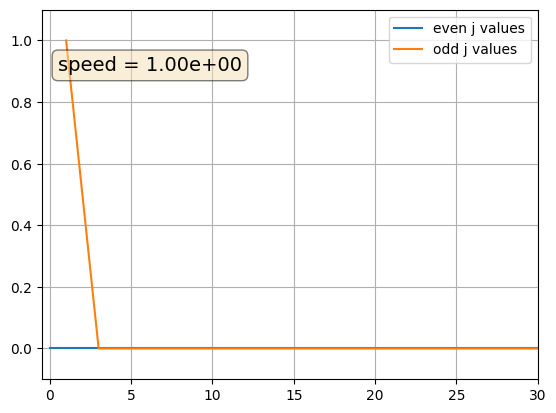

In [18]:
import matplotlib.animation as animation

solv = solv_arr[1]
l_max = np.max( solv.l_arr )
rot_prob = np.zeros( (solv.N_t, l_max + 1) )

for i, l in enumerate( solv.l_arr ):
    rot_prob[:, l] += np.abs( solv.Psi[:, i] )**2


fig, ax = plt.subplots()

leg_even, = ax.plot( np.arange( 0, l_max + 1, 2 ), rot_prob[0,::2], label = "even j" )
leg_odd, = ax.plot( np.arange( 1, l_max + 1, 2 ), rot_prob[0,1::2], label = "odd j" )

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
box = ax.text(0.5, 0.95, f"speed = {0}ps", fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlim(-0.5, 30 )
ax.set_ylim( -0.1, 1.1 )

ax.legend()
ax.grid()

speed = np.diff( solv.t ) / 1e3

def animate(i):

    t_ind = i
    max_p = np.max( rot_prob[t_ind] )

    leg_even.set_ydata(rot_prob[t_ind,::2])
    leg_odd.set_ydata(rot_prob[t_ind,1::2])
    
    box.set_text( f"speed = {speed[t_ind]:.2e}" )

    # ax.set_ylim( bottom = -0.1 * max_p, top = max_p * 1.1 )
    

    return leg_even, leg_odd, box, ax, 

ani = animation.FuncAnimation(fig, animate, repeat=False,
                                    frames=150, interval = 120 )

writer = animation.PillowWriter(fps=30,
                                metadata=dict(artist='Me'),
                                bitrate=1800)

ani.save('scatter.gif', writer="pillow")